# Test Scenarios for the Optimiser

We create a test set of scenarios since 1-Jan-2023 based on combinations of the following conditions: 
- TUL Mode: number of TULs in operation
- TLO Mode: Which TLOs are down
- Port stock yard level
- High rake availability, Low rake availability **Not Done**
- Outload circuit running, Outload circuit down **Not Done**


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as dt
import plotly.express as px
import seaborn as sns

 utilities fromimport run_query

# Stock Pile Transaction

Take the daily balance from the first transaction per stockpile each day. Since some days may not have a transaction, resample each stock pile to a daily time series using back fill, then sum over the stockpiles to get an accurate daily total

In [2]:
# For each port stockpile get the first transaction for the day. 
# Note there may be days without transations
df_stockpile = run_query(  '''
    select stockpile_name, transaction_datetime, balance_wmt
    from SBX_AA_OPERATIONS_ARTIFICIALINTELLIGENCE.STG_ARTIFICIALINTELLIGENCE.kmc_stg_delta__inventory_stockpile_transactions
    where stockpile_type = 'PortStockpile' 
        and transaction_datetime > '2023-01-01' 
        and stockpile_name NOT LIKE '__ -%'  -- remove base and winrows
    
    qualify row_number() over (partition by stockpile_name, DATE(transaction_datetime) order by transaction_datetime) = 1 -- get the first reading for the day
    order by stockpile_name,  DATE(transaction_datetime)
'''
)
# make compatable with other timeseries
df_stockpile.TRANSACTION_DATETIME = df_stockpile.TRANSACTION_DATETIME.dt.tz_localize(None)                         
df_stockpile = df_stockpile.set_index(['TRANSACTION_DATETIME'], drop=True)
assert len(df_stockpile.STOCKPILE_NAME.unique()) == 6*6, "Incorrect number of stockpiles"

# Ensure there is a reading for each day for each stockpile
df_stockpile = df_stockpile.groupby('STOCKPILE_NAME', group_keys=False).resample("D").bfill()

# Create a daily sum by adding all the stockpiles for each date
df_stockpile = df_stockpile.BALANCE_WMT.groupby('TRANSACTION_DATETIME').sum()

<Axes: xlabel='StartTime', ylabel='BALANCE_WMT'>

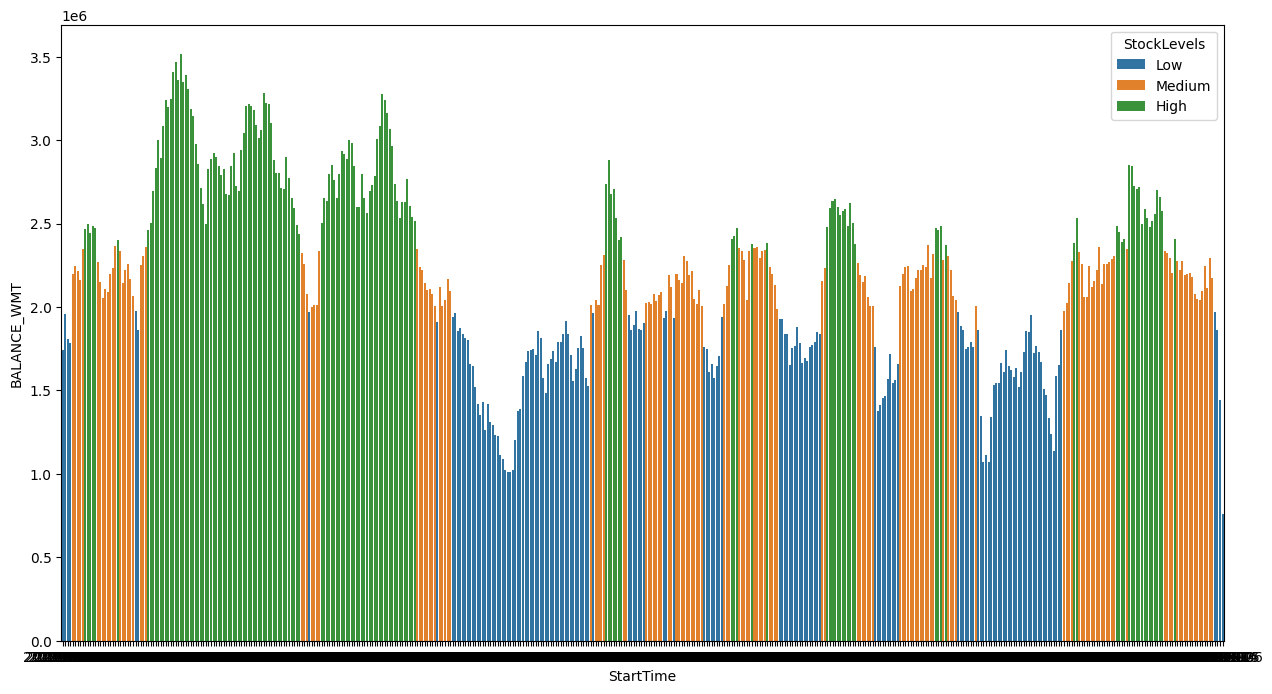

In [3]:
# categorise each day as low/medium/high
low, high = (df_stockpile.quantile(1/3), df_stockpile.quantile(2/3))
condition = [df_stockpile < low,  df_stockpile.between(low, high) , high <= df_stockpile]
category = np.select(condition, ["Low", "Medium", "High"])

#create a dataframe with these totals/categories
df_stockpile_total = df_stockpile.to_frame()
df_stockpile_total['StockLevels'] = category
df_stockpile_total['StartTime'] = df_stockpile_total.index.astype('datetime64[ms]')
df_stockpile_total = df_stockpile_total.reset_index(drop=True).sort_values('StartTime')[['StartTime', 'StockLevels', 'BALANCE_WMT' ]]

plt.figure(figsize=(15,8))
sns.barplot(data = df_stockpile_total, x='StartTime', y="BALANCE_WMT", hue="StockLevels")

# TUL

In [4]:
# Load the TLO outage data
df_tul_raw = run_query("""
    select "StartTime", "EndTime", "Circuit"
    from EDW.SELFSERVICE."APLUS_vwEventAllocation"
    where "EventProductionDay" >= '2023-01-01 00:00'
        and "TimeUsageCode" in ('SM', 'UM') 
        and ("Circuit" in ('Inload 1', 'Inload 2', 'Inload 3') and "Area" = 'AP Inloading')
    order by "StartTime"
"""
)
print(len(df_tul_raw),  "rows of data")

1887 rows of data


In [5]:
def infill(df: pd.DataFrame, circuit) -> pd.DataFrame:
        '''Take a timeseries of when an indvidual circit is down and infill with
        the empty spaces with the periods it is up.'''
        df1 = df.query(f"Circuit == '{circuit}'").drop(columns = 'Circuit').copy().sort_values('StartTime')
        df1[circuit] = 'Down'
        df2 = pd.DataFrame(
                {'StartTime': df1['EndTime'], 
                 circuit: 'Up'}
        )
        return pd.concat([df1, df2]).sort_values('StartTime').set_index('StartTime', drop=True).drop(columns = 'EndTime')
      
# Create a timeseries with a column for each TUL showing the status (Up/Down)
df1 = infill(df_tul_raw, "Inload 1")
df2 = infill(df_tul_raw, "Inload 2")
df3 = infill(df_tul_raw, "Inload 3")

# join the three circuites and use ffill to propergate the status
df_tul = pd.concat([df1, df2, df3]).sort_index().ffill().fillna("Up").reset_index()

# remove events of zero duration
df_tul['EndTime'] = df_tul['StartTime'].shift(-1)
df_tul = df_tul.query('StartTime != EndTime') 

# Calcuate the mode and coalesce neighboring events of the same Mode
df_tul['TUL_Mode'] = df_tul[["Inload 1", "Inload 2", "Inload 3"]].agg(lambda x: x.str.contains('Up')).sum(1)
df_tul = df_tul[df_tul["TUL_Mode"] != df_tul["TUL_Mode"].shift(-1)]

# Now the endtimes and durations need to be updated
df_tul['EndTime'] = df_tul['StartTime'].shift(-1)
df_tul['Duration'] = (df_tul.EndTime - df_tul.StartTime)
df_tul['Duration_Hrs'] = ((df_tul.EndTime - df_tul.StartTime) / pd.Timedelta(hours=1)).round(2)

assert len(df_tul[df_tul['Duration_Hrs'] < 0]) == 0, "Duration Hrs should be greater than or equal to zero"

df_tul = pd.merge_asof(df_tul[:-2], df_stockpile_total, on = "StartTime")
df_tul.to_csv('df_tul.csv')
px.timeline(df_tul, x_start="StartTime", x_end="EndTime", y="TUL_Mode", hover_data="Duration_Hrs", color='StockLevels')

## Remove short 3-TUL mode events

In [6]:
# Remove short duration 3-TUL events that can mask long  2-TUL events 
df_tul2 = df_tul[~((df_tul["TUL_Mode"] == 3 ) & (df_tul["Duration_Hrs"] < .5))].copy()

#remove zero duration events
df_tul2['EndTime'] = df_tul2['StartTime'].shift(-1)
df_tul2 = df_tul2.query('StartTime != EndTime') 

# coalesces neighboring events of the same mode
df_tul2 = df_tul2[~((df_tul2["TUL_Mode"] == df_tul2["TUL_Mode"].shift(1) ))].copy()

# Now these have been cleaned up, compute the new EndTime and Duration
df_tul2['EndTime'] = df_tul2['StartTime'].shift(-1)
df_tul2['Duration'] = (df_tul2.EndTime - df_tul2.StartTime)
df_tul2['Duration Hrs'] = ((df_tul2.EndTime - df_tul2.StartTime) / pd.Timedelta(hours=1)).round(2)
px.timeline(df_tul2, x_start="StartTime", x_end="EndTime", y="TUL_Mode", hover_data="Duration_Hrs", color='StockLevels')

In [7]:
def gaps(df_tul):
        df = df_tul[df_tul['TUL_Mode']  == 3]
        df_gaps =  pd.DataFrame(
                        {'StartTime': df['EndTime'], 
                        'EndTime': df['StartTime'].shift(-1),
                        'TUL Mode': "Not 3"
                        }
                )
        df_gaps['Duration_Hrs'] = ((df_gaps.EndTime - df_gaps.StartTime) / pd.Timedelta(hours=1)).round(2)
        return df_gaps

df_not_3_tul = pd.merge_asof(gaps(df_tul2)[:-2], df_stockpile_total, on = "StartTime")

# TLO

Load planed (SM) and unplaned (UM) maintainace for TLOs

In [8]:
df_tlo_raw = run_query("""
    select "StartTime", "EndTime", "Region", "Area", "Circuit", "TimeUsageCode", "EquipmentType", "Department"
    from EDW.SELFSERVICE."APLUS_vwEventAllocation"
    where "EventProductionDay" >= '2023-01-01 06:00'
    and "TimeUsageCode" in ('SM', 'UM') 
    and "Circuit" in ('SM TLO', 'CB TLO', 'CC TLO', 'EW TLO')
    order by "Circuit", "StartTime"
"""
)
assert len(df_tlo_raw.Circuit.unique()) == 4

In [9]:
# To get a more accurate picture of the downtime
# merge neighboring rows where the start time of the next row is less than 30 min after the end time of the current row
df_tlo = df_tlo_raw
df_tlo['mask'] = ~(df_tlo_raw.StartTime <= df_tlo_raw.EndTime.shift(1) + pd.Timedelta(minutes=30) )
df_tlo['change_group'] = df_tlo['mask'].cumsum() 
df_tlo = df_tlo.groupby(['Circuit', 'change_group']).agg({'StartTime': min, 'EndTime':max}).reset_index(drop=False).drop(columns='change_group')

df_tlo['Duration'] = (df_tlo.EndTime - df_tlo.StartTime)
df_tlo['Duration_Hrs'] = ((df_tlo.EndTime - df_tlo.StartTime) / pd.Timedelta(hours=1)).round(2)
px.timeline(df_tlo, x_start="StartTime", x_end="EndTime", y="Circuit", hover_data="Duration_Hrs")

/tmp/ipykernel_19228/1279426528.py:6: FutureWarning:

The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.

/tmp/ipykernel_19228/1279426528.py:6: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.



# Scenarios

In [10]:
# Create sceanarios for High, Medium and low stockpiles
df1 = pd.concat([df_stockpile_total.nlargest(1, "BALANCE_WMT"),
                df_stockpile_total[df_stockpile_total['BALANCE_WMT']==df_stockpile_total['BALANCE_WMT'].quantile(interpolation='nearest')],
            df_stockpile_total.nsmallest(1, "BALANCE_WMT")]).reset_index(drop=True)[['StartTime', 'StockLevels']]
df1 = pd.merge_asof(df1, df_tul[['StartTime', 'TUL_Mode', 'Duration_Hrs']], on = "StartTime")
df1['Description'] = "High, Medium and low stockpiles"
df1

,StartTime,StockLevels,TUL_Mode,Duration_Hrs,Description
0,2023-02-17,High,3,8.38,"High, Medium and low stockpiles"
1,2023-08-30,Medium,3,10.31,"High, Medium and low stockpiles"
2,2024-04-06,Low,1,11.08,"High, Medium and low stockpiles"


In [11]:
# Create sceanrios for TUL mode less than 3 and duration longer than 24 hours
# While TUL_mode is 2, during this period it may fall to 1 or 0
df2 = df_not_3_tul.query('Duration_Hrs >= 24').sort_values('Duration_Hrs', ascending=False)[['StartTime', 'Duration_Hrs', 'StockLevels']].sort_values('StartTime')
df2['Description'] = "TUL-2 (or lower) modes lasting longer than 24 hrs"
df2 = pd.merge_asof(df2, df_tul[['StartTime', 'TUL_Mode']], on = "StartTime")
df2

,StartTime,Duration_Hrs,StockLevels,Description,TUL_Mode
0,2023-01-14 06:00:00,36.00,High,TUL-2 (or lower) modes lasting longer than 24 hrs,2
1,2023-01-28 06:00:00,60.00,Medium,TUL-2 (or lower) modes lasting longer than 24 hrs,2
2,2023-04-07 18:00:00,48.00,Medium,TUL-2 (or lower) modes lasting longer than 24 hrs,2
3,2023-04-27 20:00:00,46.00,High,TUL-2 (or lower) modes lasting longer than 24 hrs,2
4,2023-04-30 06:00:00,24.00,High,TUL-2 (or lower) modes lasting longer than 24 hrs,2
5,2023-05-11 18:00:00,46.87,High,TUL-2 (or lower) modes lasting longer than 24 hrs,2
6,2023-07-13 18:00:00,36.00,Low,TUL-2 (or lower) modes lasting longer than 24 hrs,2
7,2023-07-20 18:00:00,36.00,Low,TUL-2 (or lower) modes lasting longer than 24 hrs,2
8,2023-07-26 18:00:00,60.00,Low,TUL-2 (or lower) modes lasting longer than 24 hrs,2
9,2023-09-10 16:46:35,25.22,Medium,TUL-2 (or lower) modes lasting longer than 24 hrs,2


In [12]:
#TUL mode 1 or less
df3 = df_tul.query('TUL_Mode <=1 and Duration_Hrs >= 8').sort_values('Duration_Hrs', ascending=False)[['StartTime', 'TUL_Mode', 'Duration_Hrs', 'StockLevels']]
df3['Description'] = "Tul-1 (or lower) modes lasting longer than 8 hrs"
df3 

,StartTime,TUL_Mode,Duration_Hrs,StockLevels,Description
2731,2023-11-28 13:35:05,1,16.42,Low,Tul-1 (or lower) modes lasting longer than 8 hrs
1552,2023-07-12 01:52:00,1,14.98,Low,Tul-1 (or lower) modes lasting longer than 8 hrs
225,2023-01-28 15:43:05,1,14.28,Medium,Tul-1 (or lower) modes lasting longer than 8 hrs
2123,2023-09-12 17:18:45,1,12.69,Medium,Tul-1 (or lower) modes lasting longer than 8 hrs
2113,2023-09-10 18:00:00,1,12.00,Medium,Tul-1 (or lower) modes lasting longer than 8 hrs
1703,2023-07-27 18:07:05,1,11.88,Low,Tul-1 (or lower) modes lasting longer than 8 hrs
3281,2024-04-05 18:55:20,1,11.08,Low,Tul-1 (or lower) modes lasting longer than 8 hrs
1038,2023-05-12 06:58:15,1,11.03,High,Tul-1 (or lower) modes lasting longer than 8 hrs
101,2023-01-14 07:44:20,1,10.26,High,Tul-1 (or lower) modes lasting longer than 8 hrs
1036,2023-05-11 19:52:21,1,10.13,High,Tul-1 (or lower) modes lasting longer than 8 hrs


In [13]:
df4 = df_tlo.query("Duration_Hrs > 8").sort_values("Duration_Hrs", ascending=False)[['StartTime', 'Circuit', 'Duration_Hrs']].sort_values('StartTime')

df4 = pd.merge_asof(df4, df_stockpile_total[['StartTime', 'StockLevels']], on = "StartTime")
df4['Description'] = "A TLO is down for more than 8 hours"
df4

,StartTime,Circuit,Duration_Hrs,StockLevels,Description
0,2023-01-02 14:55:00,SM TLO,11.18,Low,A TLO is down for more than 8 hours
1,2023-01-13 06:00:00,CB TLO,82.55,High,A TLO is down for more than 8 hours
2,2023-01-27 03:49:00,SM TLO,50.02,Medium,A TLO is down for more than 8 hours
3,2023-01-29 17:56:00,SM TLO,31.15,Medium,A TLO is down for more than 8 hours
4,2023-02-28 03:29:00,CC TLO,146.08,High,A TLO is down for more than 8 hours
5,2023-03-20 05:53:35,EW TLO,52.88,High,A TLO is down for more than 8 hours
6,2023-03-26 06:00:00,EW TLO,24.00,High,A TLO is down for more than 8 hours
7,2023-04-03 10:42:30,CB TLO,133.75,High,A TLO is down for more than 8 hours
8,2023-04-28 07:16:01,SM TLO,135.52,High,A TLO is down for more than 8 hours
9,2023-06-24 06:00:00,EW TLO,173.57,Low,A TLO is down for more than 8 hours


In [14]:
df_sceanarios = pd.concat([df1, df2, df3, df4]).reset_index(drop=True)[['StartTime', 'StockLevels', 'TUL_Mode', 'Circuit', 'Duration_Hrs', 'Description']]
df_sceanarios.to_csv('sceanarios.csv')
df_sceanarios

,StartTime,StockLevels,TUL_Mode,Circuit,Duration_Hrs,Description
0,2023-02-17 00:00:00,High,3.0,NaN,8.38,"High, Medium and low stockpiles"
1,2023-08-30 00:00:00,Medium,3.0,NaN,10.31,"High, Medium and low stockpiles"
2,2024-04-06 00:00:00,Low,1.0,NaN,11.08,"High, Medium and low stockpiles"
3,2023-01-14 06:00:00,High,2.0,NaN,36.00,TUL-2 (or lower) modes lasting longer than 24 hrs
4,2023-01-28 06:00:00,Medium,2.0,NaN,60.00,TUL-2 (or lower) modes lasting longer than 24 hrs
...,...,...,...,...,...,...
64,2024-01-27 18:08:30,Low,NaN,SM TLO,36.58,A TLO is down for more than 8 hours
65,2024-01-30 00:14:00,Low,NaN,SM TLO,55.30,A TLO is down for more than 8 hours
66,2024-02-21 03:52:00,Medium,NaN,CC TLO,151.28,A TLO is down for more than 8 hours
67,2024-03-15 06:00:00,Medium,NaN,EW TLO,253.25,A TLO is down for more than 8 hours
